===================================================
### Code developed by: Yushen Lin

### Contact: yl2020@ic.ac.uk
===================================================

# Import modules

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time
import joblib

from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

In [3]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
os.chdir('/content/gdrive/MyDrive/dimension reduction')

In [5]:
! pip install vtk -q
! pip install meshio -q
! pip install cmocean -q

     |████████████████████████████████| 59.5 MB 42 kB/s 
     |████████████████████████████████| 3.1 MB 67.4 MB/s 
     |████████████████████████████████| 495 kB 81.8 MB/s 
     |████████████████████████████████| 74 kB 3.8 MB/s 
     |████████████████████████████████| 3.0 MB 80.4 MB/s 
     |████████████████████████████████| 251 kB 89.9 MB/s 
     |████████████████████████████████| 1.3 MB 76.1 MB/s 
     |████████████████████████████████| 142 kB 85.4 MB/s 
     |████████████████████████████████| 294 kB 93.3 MB/s 
     |████████████████████████████████| 163 kB 13.1 MB/s 
     |████████████████████████████████| 223 kB 12.9 MB/s 


In [10]:
# scaler of the original data
scaler_std = joblib.load('output_files/scaler_std_full.pkl')
scaler_x = joblib.load('output_files/scaler_x_full.pkl')
scaler_y = joblib.load('output_files/scaler_y_full.pkl')
scaler_z = joblib.load('output_files/scaler_z_full.pkl')

autoencoder_py = joblib.load("models/autoencoder_py_43.pkl")
CO2data = joblib.load('CO2data.pkl')

# What do we need from PredGAN?

We make predictions of the POD coefficients, it is performed by starting with eight time levels from (known initial solutions) and using the generator to predict the $9^{th}$. 

X_generated takes as input some noise (the shape of the latent space) and outputs an array, the shape of which is determined by the output layer in generator. 

In this line:

X_generated = scaler.inverse_transform(generator.predict(seed).reshape(num_examples_to_generate*ntimes,codings_size))

Vinicius takes some noise "seed", puts it in the generator, reshapes it, applies the inverse scaling to it. For him, he has data split into groups and two spatial dimensions so he also reshapes with X_generated.reshape(ntimes, len(groups)*nl*nc). You will need to modify this.

In [6]:
# read the data from CFD models
def ReadData(filename):
  output = []
  sf = open(filename,'r')
  data = sf.readlines()
  for i in range(0,len(data)):
    x = str.split(data[i])
    y = [float(v) for v in x]
    output.append(y)
  return output

CO2_fluidity = ReadData('CO2_Fluidity.dat')
sensor_data = np.array(CO2_fluidity)
print(sensor_data.shape)
print(sensor_data[:,1:].shape) # no need first row(time levels) and it is not scaled

(455, 8)
(455, 7)


# Load the GAN

In [7]:
# load generator and discriminator
generator, discriminator = load_model("gan-sfc-820-afternoon3-30000.h5").layers
# ("gan-sfc-823-afternoon9-30000.h5") ok one
scaler_reduced = MinMaxScaler((-1,1))
scaler = MinMaxScaler((-1,1))
mode = 'autoencoder'

reduced_sfc = np.loadtxt('reduced_sfc.csv', delimiter=',')
X_train_scaled = scaler.fit_transform(reduced_sfc)

In [8]:
def concat_timesteps(X_train, ntimes, step):
  X_train_concat = []
  for i in range(len(X_train) - ntimes*step):
    X_train_concat.append(X_train[i:i+ntimes*step:step])
  return np.array(X_train_concat)

# how big your input in D is
ntimes = 9 # Consecutive times for the GAN
step = 1 # step between times

sensor_data_scale = scaler_reduced.fit_transform(sensor_data[:,1:])
print('shape of sensor data: ',sensor_data_scale.shape)
X_train_scaled = np.hstack((X_train_scaled, sensor_data_scale))
print('X_train_scaled: ',X_train_scaled.shape)

codings_size = X_train_scaled.shape[1]

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
print('X_train_concat', X_train_concat.shape)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes)
print('X_train_concat_flatten', X_train_concat_flatten.shape)

shape of sensor data:  (455, 7)
X_train_scaled:  (455, 50)
X_train_concat (446, 9, 50)
X_train_concat_flatten (446, 450)


In [11]:
scaler = joblib.load("scaler-minmax-sfc820-1.pkl") 

np.random.seed(0)
tf.random.set_seed(0)

npredict = 8 # Number of future steps
latent_size = 150

noise = tf.random.normal(shape=[npredict, latent_size])

if (mode=='autoencoder'):
  autoen = scaler.inverse_transform(generator.predict(noise).reshape(npredict*ntimes,codings_size))
  X_generate = torch.tensor(autoen[:,:-7])
  print(X_generate.shape)
  X_generated = autoencoder_py.decoder.to('cpu')(X_generate)

else:
  # PCA case
  X_generated = scaler.inverse_transform((generator.predict(noise).reshape(npredict*ntimes, codings_size)))
  print('X_generated.shape', X_generated.shape)
  X_generated = pca_compress.inverse_transform(X_generated)

torch.Size([72, 43])


## Set weight

In [12]:
weight = np.ones(codings_size)

# *******************  *************#
'''
try different weight based on the data 
distribution of latent vairbles
'''

#weight[3:46] = 0.1
#weight[:2] = 0.1
#weight[47:] = 0.1
# *******************  *************#

weight = tf.constant(np.asarray(weight), dtype = tf.float32)
weight

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

In [13]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-2)

def mse_loss(inp, outp, loss_weight):
  inp = tf.reshape(inp, [-1, codings_size])*tf.math.sqrt(loss_weight)
  outp = tf.reshape(outp, [-1, codings_size])*tf.math.sqrt(loss_weight)
  return mse(inp, outp)

the gradient of the loss $L_p$ is calculated with respect to the latent variables $z^n$(by back-propagation), and $L_p$ is minimised in the gradient direction leading to an updated set of latent variables $^{(l+1)}z^n$;

In [14]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
  # Record operations for automatic differentiation
  with tf.GradientTape() as tape:
    # Operations are recorded if they are executed within this context manager and at least one of their inputs is being "watched".
    tape.watch(latent_values)
    gen_output = generator(latent_values, training=False)  #results from generator
    loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
    #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

  gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
  optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
  
  return loss

def optimize_coding(real_coding, loss_weight):
  latent_values = tf.random.normal([len(real_coding), latent_size])  
  latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
  
  loss = []
  for epoch in range(10000):
    loss.append(opt_step(latent_values, real_coding, loss_weight).numpy())
      
  plt.plot(loss)
  plt.grid()
  plt.show
      
  return latent_values  #returns the optimized input that generates the desired output

In [15]:
noise = tf.random.normal(shape=[1, latent_size])
X_generated_scaler = scaler.inverse_transform(generator.predict(noise).reshape(-1,codings_size)) # scaled

if (mode=='autoencoder'):
  X_generate = torch.tensor(X_generated_scaler)

else:
  X_gen_recovered = pca_compress.inverse_transform(X_generated_scaler)
  if (np.allclose(X_train_compressed, scaler_minmax.inverse_transform(X_train_scaled)) != True):
    assert 'Please check if you load correct scaler or correct compressed data.'

In [16]:
n = 0
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
print('real_coding[:,:codings_size*(ntimes - 1): ',real_coding.shape)
real_coding = tf.constant(real_coding)
print('constant: ',real_coding.shape)

# Casts a tensor to a new type
real_coding = tf.cast(real_coding, dtype=tf.float32)

real_coding[:,:codings_size*(ntimes - 1):  (1, 400)
constant:  (1, 400)


Loss:  0.02065455


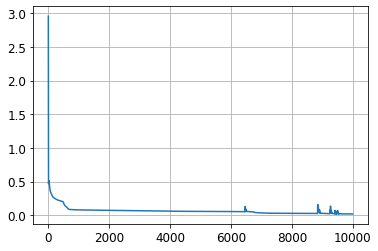

In [17]:
latent_values = optimize_coding(real_coding, weight)
print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight).numpy())

latent_values = tf.convert_to_tensor(latent_values)

# SFC-CAE or PCA recover

In [18]:
if (mode=='autoencoder'):
  '''
  X_gen[:,:-7]: (9, 43)
  X_gen[:,-7:]: (9, 7)
  '''
  X_gen = scaler.inverse_transform(generator.predict(latent_values).reshape(ntimes,codings_size))
  X_gen_pod = torch.tensor(X_gen[:,:-7])
  X_rec = autoencoder_py.decoder.to('cpu')(X_gen_pod).detach().numpy()
  print(X_rec.shape)
  S_x = scaler_x.inverse_transform(X_rec[:,:,2])
  S_y = scaler_y.inverse_transform(X_rec[:,:,3])
  S_z = scaler_z.inverse_transform(X_rec[:,:,-1])
  X_rec = scaler_std.inverse_transform(X_rec[:,:,1])
  
  X_C02 = scaler_reduced.inverse_transform(X_gen[:,-7:])
  X_rec = np.hstack((X_rec, X_C02))

  X_real = scaler.inverse_transform(X_train_concat_flatten[n].reshape(ntimes,codings_size))
  X_real_pod = torch.tensor(X_real[:,:-7])
  X_real_pod = autoencoder_py.decoder.to('cpu')(X_real_pod.float()).detach().numpy()
  R_x = scaler_x.inverse_transform(X_real_pod[:,:,2])
  R_y = scaler_y.inverse_transform(X_real_pod[:,:,3])
  R_z = scaler_z.inverse_transform(X_real_pod[:,:,-1])
  X_real_pod = scaler_std.inverse_transform(X_real_pod[:,:,1])
  co2 = scaler_reduced.inverse_transform(X_real[:,-7:])
  X_real = np.hstack((X_real_pod, co2))
  if (X_real.shape != X_rec.shape):
    assert 'The X reconstruction from prediction is not the same with the real.'

else:
  X_gen = scaler_minmax.inverse_transform(generator.predict(latent_values).reshape(ntimes,codings_size))
  X_rec = pca_compress.inverse_transform(X_gen)

  X_real = scaler_minmax.inverse_transform(X_train_concat_flatten[n].reshape(ntimes,codings_size))
  X_real = pca_compress.inverse_transform(X_real)

(9, 148906, 4)


In [22]:
if (mode=='autoencoder'):
  X = np.hsplit(X_rec, 1)
  S_CO2 = X[0]
  print(S_CO2.shape)
  print("max value of generated S_CO2 = ", np.max(S_CO2))
  print("min value of generated S_CO2 = ", np.min(S_CO2))
else:
  X = np.hsplit(X_rec, 4)
  S_CO2 = scaler_std.inverse_transform(X[0])
  S_x = scaler_x.inverse_transform(X[1])
  S_y = scaler_y.inverse_transform(X[2])
  S_z = scaler_z.inverse_transform(X[3])
  
  print("max value of generated S_CO2 = ", np.max(S_CO2))
  print("min value of generated S_CO2 = ", np.min(S_CO2))
  if (X[0].shape!=(9, 148906) and X[1].shape!=(9, 148906) and X[2].shape!=(9, 148906) and X[3].shape!=(9, 148906)):
    assert 'plase check your sizes of spliting the data.'

(9, 148913)
max value of generated S_CO2 =  1436.0
min value of generated S_CO2 =  402.79526


In [23]:
if (mode=='autoencoder'):  
  Real = np.hsplit(X_real, 1)
  R_CO2 = Real[0]
  print(R_CO2.shape)
  #R_CO2 = scaler_reduced.inverse_transform(Real[0][:,-7:])
  print("max value of R_CO2 = ", np.max(Real))
  print("min value of R_CO2 = ", np.min(Real))

else:
  Real = np.hsplit(X_real, 4)
  R_CO2 = scaler_std.inverse_transform(Real[0])
  R_x = scaler_x.inverse_transform(Real[1])
  R_y = scaler_y.inverse_transform(Real[2])
  R_z = scaler_z.inverse_transform(Real[3])
  print("max value of R_CO2 = ", np.max(R_CO2))
  print("min value of R_CO2 = ", np.min(R_CO2))

(9, 148913)
max value of R_CO2 =  1436.0
min value of R_CO2 =  400.4726582451255


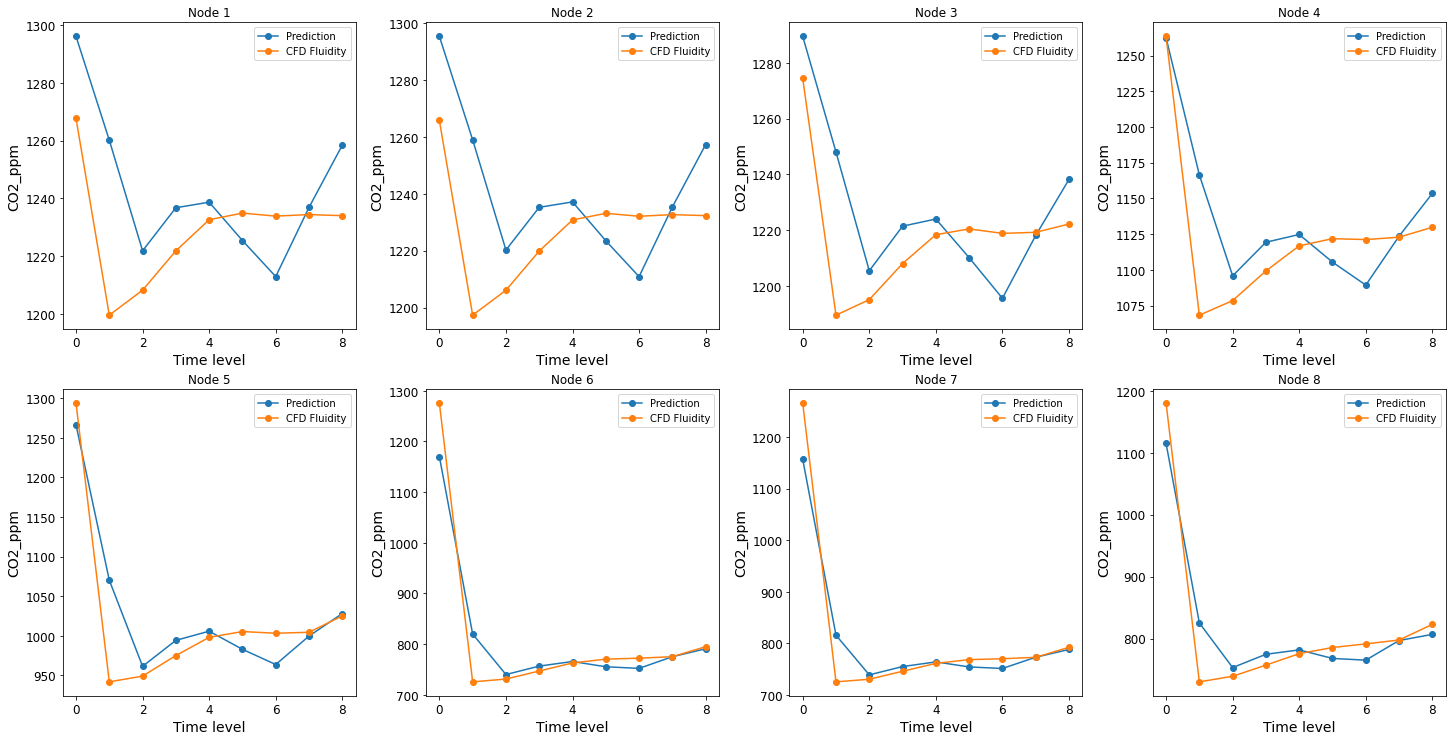

In [24]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(8):
  ax.flatten()[i].plot(S_CO2[:,i], '-o')
  ax.flatten()[i].plot(R_CO2[:,i], '-o')
  ax.flatten()[i].legend(['Prediction','CFD Fluidity'])
  ax.flatten()[i].set_title('Node '+ str(i+1))
  ax.flatten()[i].set_xlabel('Time level')
  ax.flatten()[i].set_ylabel('CO2_ppm')

Velocity in x

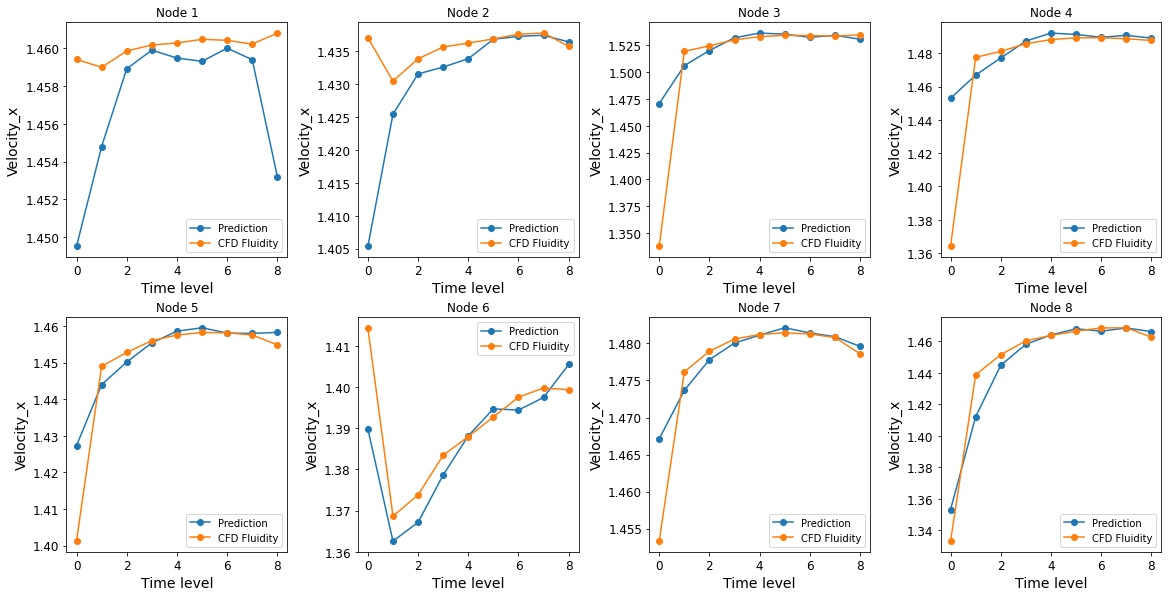

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[16,8])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(8):
  ax.flatten()[i].plot(S_x[:,i*60], '-o', label='Prediction')
  ax.flatten()[i].plot(R_x[:,i*60], '-o', label='CFD Fluidity')
  ax.flatten()[i].legend()
  ax.flatten()[i].set_title('Node '+ str(i+1))
  ax.flatten()[i].set_xlabel('Time level')
  ax.flatten()[i].set_ylabel('Velocity_x')

Velocity in y

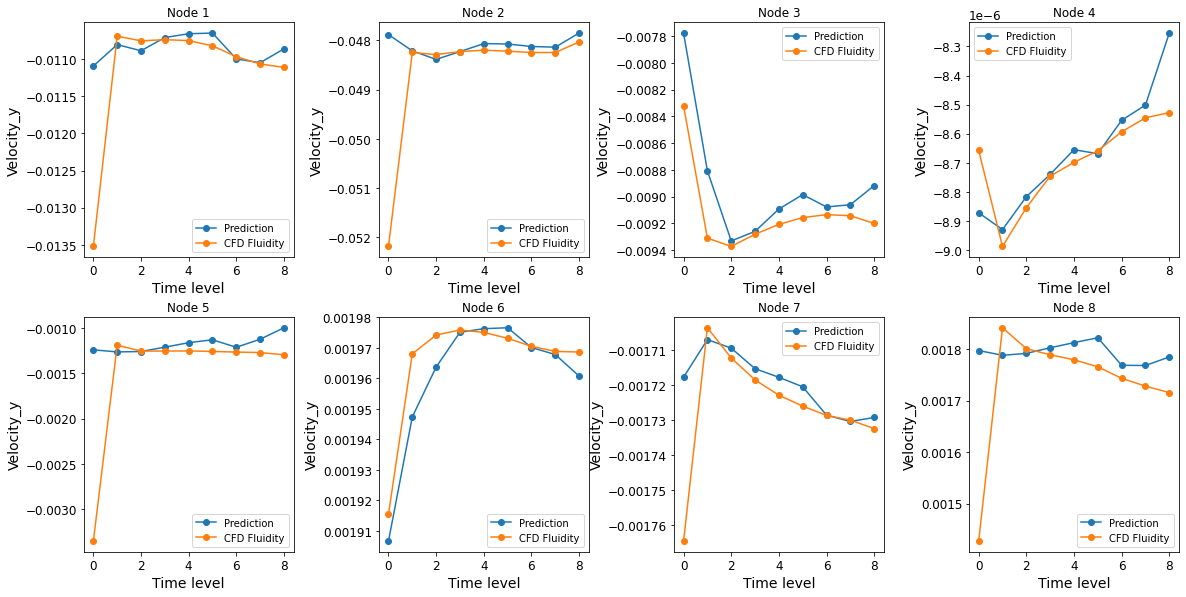

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[16,8])
fig.tight_layout(h_pad=3.5, w_pad=5)
for i in range(8):
  ax.flatten()[i].plot(S_y[:,i*200], '-o', label='Prediction')
  ax.flatten()[i].plot(R_y[:,i*200], '-o', label='CFD Fluidity')
  ax.flatten()[i].legend()
  ax.flatten()[i].set_title('Node '+ str(i+1))
  ax.flatten()[i].set_xlabel('Time level')
  ax.flatten()[i].set_ylabel('Velocity_y')

velocity in z

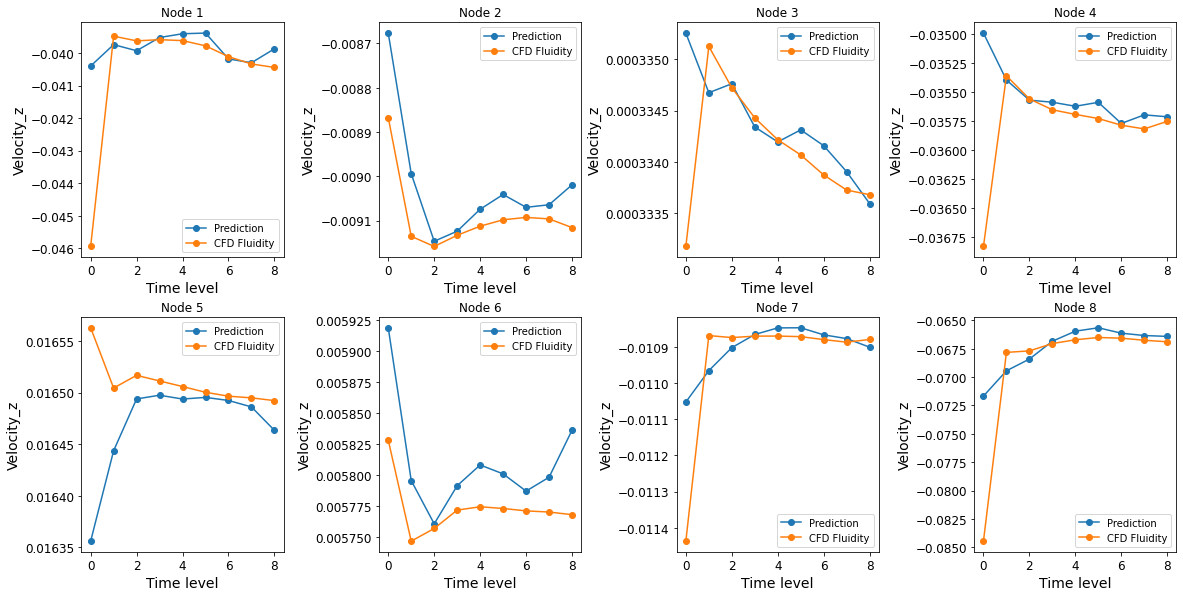

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[16,8])
fig.tight_layout(h_pad=3.5, w_pad=6)
for i in range(8):
  ax.flatten()[i].plot(S_z[:,i*399], '-o', label='Prediction')
  ax.flatten()[i].plot(R_z[:,i*399], '-o', label='CFD Fluidity')
  ax.flatten()[i].legend()
  ax.flatten()[i].set_title('Node '+ str(i+1))
  ax.flatten()[i].set_xlabel('Time level')
  ax.flatten()[i].set_ylabel('Velocity_z')

In [ ]:
import vtktools
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file
# /content/gdrive/MyDrive/dimension reduction/ClarenceData/'
def write_example_to_vtu(exm_num,verbose):
  # get clean vtu file
  if (verbose==True):
    snapshot_data_location = '/content/gdrive/MyDrive/dimension reduction/ClarenceData/'
    snapshot_file_base = 'ClarenceCentre_'
    filename = snapshot_data_location + snapshot_file_base + '0.vtu'
    clean_vtu = get_clean_vtu_file(filename)

    # write results to vtu
    nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
    CO2_ppm = np.zeros((nNodes,1))
    velocity = np.zeros((nNodes,3))

    new_vtu = vtktools.vtu()
    new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
    new_vtu.filename = 'predictions/prediction' + str(exm_num) + '.vtu'

    CO2_ppm[:] = S_CO2[exm_num].reshape((148906, 1),order='F')
    # for j in range(3):
    velocity[:,0] = S_x[exm_num].reshape((148906),order='F')
    velocity[:,1] = S_y[exm_num].reshape((148906),order='F') 
    velocity[:,2] = S_z[exm_num].reshape((148906),order='F') 
 
    new_vtu.AddField('CO2_ppm', CO2_ppm)
    new_vtu.AddField('Velocity', velocity)
    new_vtu.Write()

def write_to_vtu(verbose=False):  
  if (verbose==True):  
    for i in range(8):
      write_example_to_vtu(i)
verbose=False
write_to_vtu(verbose)

## Sensor predictions

In [ ]:
os.chdir('/content/gdrive/MyDrive/dimension reduction/sensors_data/')
num_files = len([name for name in os.listdir('.') if os.path.isfile(name)])
sensor_data = {}

for i in range(1,num_files+1):
  fname = 'Sensor'+ str(i) + '_NodeIDs.dat'
  sensor_data['sensor{0}'.format(i)] = np.loadtxt(fname, unpack = True)

In [ ]:
def cal_sensors(sensor_data):
  pred = {}; real = {}
  for i in range(1,num_files+1):
    sensor_num = 'sensor' + str(i)
    pred['pred{0}'.format(i)] = (S_CO2[:,int(sensor_data[sensor_num][0])] + S_CO2[:,int(sensor_data[sensor_num][1])]
                      + S_CO2[:,int(sensor_data[sensor_num][2])] + S_CO2[:,int(sensor_data[sensor_num][3])])/4
                      
    real['real{0}'.format(i)] = (R_CO2[:,int(sensor_data[sensor_num][0])] + R_CO2[:,int(sensor_data[sensor_num][1])]
                      + R_CO2[:,int(sensor_data[sensor_num][2])] + R_CO2[:,int(sensor_data[sensor_num][3])])/4
  return pred, real

pred, real = cal_sensors(sensor_data)
pred_sensor = np.vstack((pred['pred1'],pred['pred2'],pred['pred3'],pred['pred4'],pred['pred5'],pred['pred6'],pred['pred7']))
real_sensor = np.vstack((real['real1'],real['real2'],real['real3'],real['real4'],real['real5'],real['real6'],real['real7']))

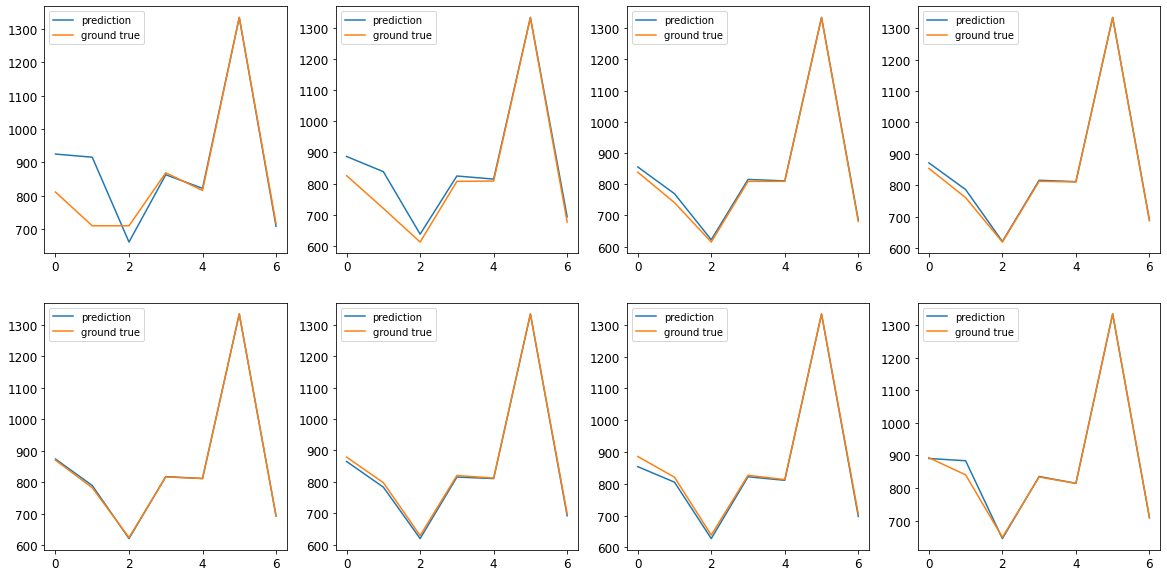

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i in range(8):
  ax.flatten()[i].plot(pred_sensor[:,i],'-')
  ax.flatten()[i].plot(real_sensor[:,i],'-')
  ax.flatten()[i].legend(['prediction','ground true'])
#plt.savefig('sensor_400.png')

In [ ]:
def optimize_coding(latent_values, real_coding, loss_weight, epochs=1000):  
  for epoch in range(epochs):
    opt_step(latent_values, real_coding, loss_weight)
        
  return latent_values  #returns the optimized input that generates the desired output

@tf.function
def opt_step(latent_values, real_coding, loss_weight):
  with tf.GradientTape() as tape:
    tape.watch(latent_values)
    gen_output = generator(latent_values, training=False)  #results from generator
    loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
    #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

  gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
  optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
  
  return loss

# Whole prediction

In [ ]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
  with tf.GradientTape() as tape:
    tape.watch(latent_values)
    gen_output = generator(latent_values, training=False)  #results from generator
    loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
    #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

  gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
  optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
  
  return loss

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

n = 0
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_size])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(446): 
  latent_values = optimize_coding(latent_values, real_coding, weight, epochs=1000)
  gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
  X_predict.append(gen_predict.flatten())
  real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
  real_coding = tf.constant(real_coding)
  real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [ ]:
X_generated = torch.tensor(X_predict)
X_generated_try = autoencoder_py.decoder.to('cpu')(X_generated[:,:-7]).detach().numpy()
print(X_generated_try.shape)
X_generated1 = scaler_std.inverse_transform(X_generated_try[:,:,1])
S_x = scaler_x.inverse_transform(X_generated_try[:,:,2])
S_y = scaler_y.inverse_transform(X_generated_try[:,:,3])
S_z = scaler_z.inverse_transform(X_generated_try[:,:,-1])
print('std: ',X_generated1)

(455, 148906, 4)
std:  [[1283.667   1282.5913  1271.8557  ...  824.1088  1301.0952   675.468  ]
 [1271.622   1270.475   1252.166   ...  826.68524 1302.2876   673.52515]
 [1266.7618  1265.5574  1244.523   ...  828.17194 1303.7911   673.3388 ]
 ...
 [ 652.67993  653.1614   659.9483  ...  802.8819   676.977    630.8639 ]
 [ 654.72174  655.2475   662.56464 ...  802.29517  675.8595   630.9636 ]
 [ 657.2714   657.8375   665.68445 ...  801.76056  674.9233   631.0817 ]]


In [ ]:
os.chdir('/content/gdrive/MyDrive/dimension reduction')
reduced_sfc = np.loadtxt('reduced_sfc.csv', delimiter=',')

In [ ]:
reduced_sfc = torch.tensor(reduced_sfc)
X_real = autoencoder_py.decoder.to('cpu')(reduced_sfc.float()).detach().numpy()
R_CO2 = scaler_std.inverse_transform(X_real[:,:,1])
R_x = scaler_x.inverse_transform(X_real[:,:,2])
R_y = scaler_y.inverse_transform(X_real[:,:,3])
R_z = scaler_z.inverse_transform(X_real[:,:,-1])

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[16,8])
fig.tight_layout(h_pad=3.5, w_pad=3.5)

for i in range(8):
  ax.flatten()[i].plot(X_generated1[:455,i*1000], '-')
  ax.flatten()[i].plot(R_CO2[:455,i*1000], '-')
  ax.flatten()[i].legend(['PredGAN Prediction', 'Fluidity CFD'])
  ax.flatten()[i].set_title('Node '+ str((i+1)*400))
  ax.flatten()[i].set_xlabel('Time level')
  ax.flatten()[i].set_ylabel('CO2_ppm') 

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[16,8])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(8):
  ax.flatten()[i].plot(S_x[:455,i*200], '-')
  ax.flatten()[i].plot(R_x[n:455,i*200], '-')
  ax.flatten()[i].legend(['PredGAN Prediction', 'Fluidity CFD'])
  ax.flatten()[i].set_title('Node '+ str(i+1))
  ax.flatten()[i].set_xlabel('Time level')
  ax.flatten()[i].set_ylabel('Velocity_x') 

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[16,8])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(8):
  ax.flatten()[i].plot(S_y[:455,i*200], '-')
  ax.flatten()[i].plot(R_y[n:455,i*200], '-')
  ax.flatten()[i].legend(['PredGAN Prediction', 'Fluidity CFD'])
  ax.flatten()[i].set_title('Node '+ str(i+1))
  ax.flatten()[i].set_xlabel('Time level')
  ax.flatten()[i].set_ylabel('Velocity_y') 

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[16,8])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(8):
  ax.flatten()[i].plot(S_z[:455,i*20], '-')
  ax.flatten()[i].plot(R_z[n:455,i*20], '-')
  ax.flatten()[i].legend(['PredGAN Prediction', 'Fluidity CFD'])
  ax.flatten()[i].set_title('Node '+ str(i+1))
  ax.flatten()[i].set_xlabel('Time level')
  ax.flatten()[i].set_ylabel('Velocity_z') 

## Sensor prdiction

sensor locations

In [ ]:
# These node positions are given in ^Sensor'i'_NodeIDs.dat^
sensor = [10492,5482,5749,830,
      87417,89951,82864,89953,
      126524,125064,129051,124499,
      117412,117411,117031,120066,
      68542,73941,80363,68483,
      25412,38597,38720,39098,
      38425,37957,101745,39539]

In [ ]:
scaler = joblib.load("scaler-minmax-sfc823-111.pkl") 
X_sensor = scaler.inverse_transform(X_predict)
print(X_sensor.shape)

(455, 50)


## plot the prediction of CO2 at the sensor location

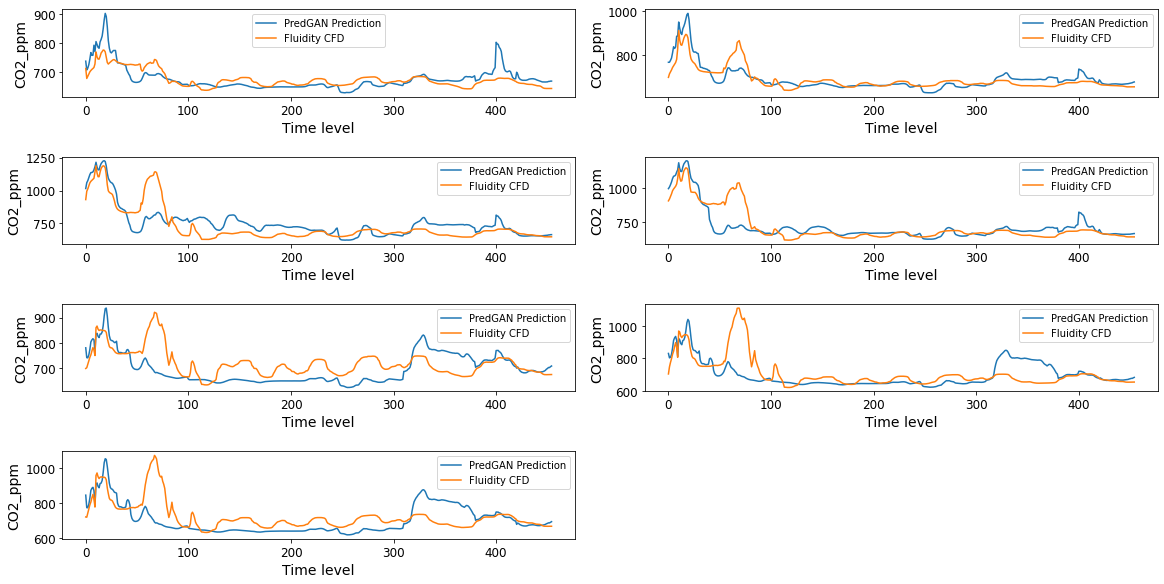

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[16,8])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(7):
  ax.flatten()[i].plot(X_generated1[:455,sensor[i]], '-')
  ax.flatten()[i].plot(R_CO2[:455,sensor[i]], '-')
  ax.flatten()[i].legend(['PredGAN Prediction', 'Fluidity CFD'])
  ax.flatten()[i].set_xlabel('Time level')
  ax.flatten()[i].set_ylabel('CO2_ppm')     
fig.delaxes(ax[3,1])